In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

from datetime import date
import time
import calendar
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd

current_date_and_time = time.time() #get the current epoch time

LastDate = int(current_date_and_time) #change the current date into integer format so as to fit into CSV link below

now = datetime.now() #get today's date

last10year = now + relativedelta(years=-10) #get the date 2 years ago from today

last10year_string = last10year.strftime("%a %b %d %H:%M:%S %Y")

StartDate = int(calendar.timegm(time.strptime(last10year_string))) #get the epoch time for the date 2 years ago and convert it to integer

Tickers = ['TSCO.L', 'SBRY.L', '3382.T', 'CA.PA', 'AXFO.ST', 'KR', 'WMT'] #ticker list

dataset = {} #create a dictionary object for containing the stock price for every ticker

#iterate each ticker in the ticker list
for Ticker in Tickers:
        #read the csv file dynamically for every ticker
	df = pd.read_csv(f'https://query1.finance.yahoo.com/v7/finance/download/{Ticker}?period1={StartDate}&period2={LastDate}&interval=1d&events=history&includeAdjustedClose=true')
	df['Ticker'] = Ticker
	dataset[Ticker] = df
	#time.sleep(1)

StockPrice = pd.concat(dataset) #put stock prices of all tickers together in one table 
StockPrice = StockPrice.reset_index(drop = True) #reset the index
StockPrice = StockPrice.set_index('Ticker')

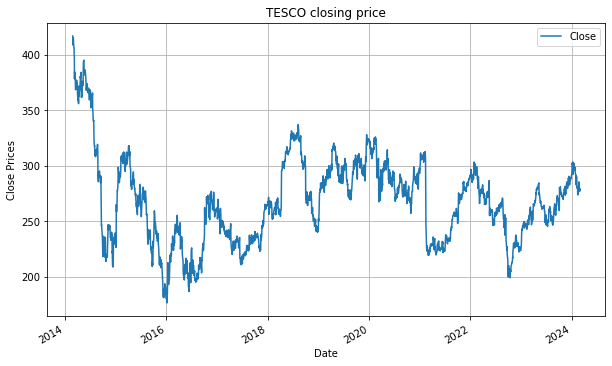

In [2]:
#plot close price in a line chart
Tesco_close = StockPrice.loc['TSCO.L', ['Date', 'Close']]
Tesco_close.reset_index(drop=True, inplace=True)
Tesco_close['Date'] = pd.to_datetime(Tesco_close['Date'], format='%Y-%m-%d') #convert dates to datetime objects
Tesco_close.plot('Date', 'Close', figsize=(10,6))

plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.title('TESCO closing price')
plt.show()

Text(0.5, 1.0, 'Probability distribution of TESCO stock price')

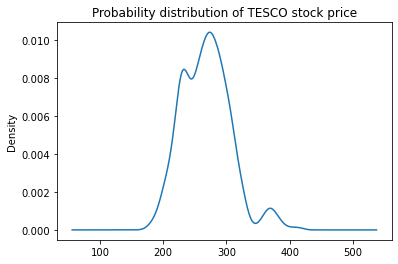

In [3]:
#probability distribution of stock price
Tesco_close['Close'].plot(kind = 'kde')
plt.title ('Probability distribution of TESCO stock price')

In [4]:
#remove null values of closing price
Tesco_close.dropna(subset = ["Close"], axis=0, inplace=True)
Tesco_close.Close.isnull().sum()
Tesco_close = Tesco_close.set_index('Date')
Tesco_close

,Close
Date,
2014-02-28,416.986389
2014-03-03,408.689789
2014-03-04,415.339813
2014-03-05,414.833099
2014-03-06,410.653107
...,...
2024-02-23,279.700012
2024-02-26,278.500000
2024-02-27,277.600006


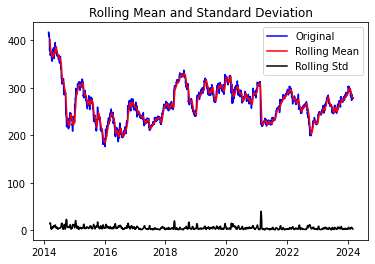

Results of dickey fuller test
Test Statistics                  -4.084187
p-value                           0.001028
No. of lags used                  1.000000
Number of observations used    2524.000000
critical value (1%)              -3.432943
critical value (5%)              -2.862686
critical value (10%)             -2.567380
dtype: float64


In [5]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    #timeseries.plot(x = 'Date', y = 'Close', figsize=(10,6), color='blue',label='Original')
    plt.plot(timeseries.Close, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries.Close,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(Tesco_close)

<Figure size 432x288 with 0 Axes>

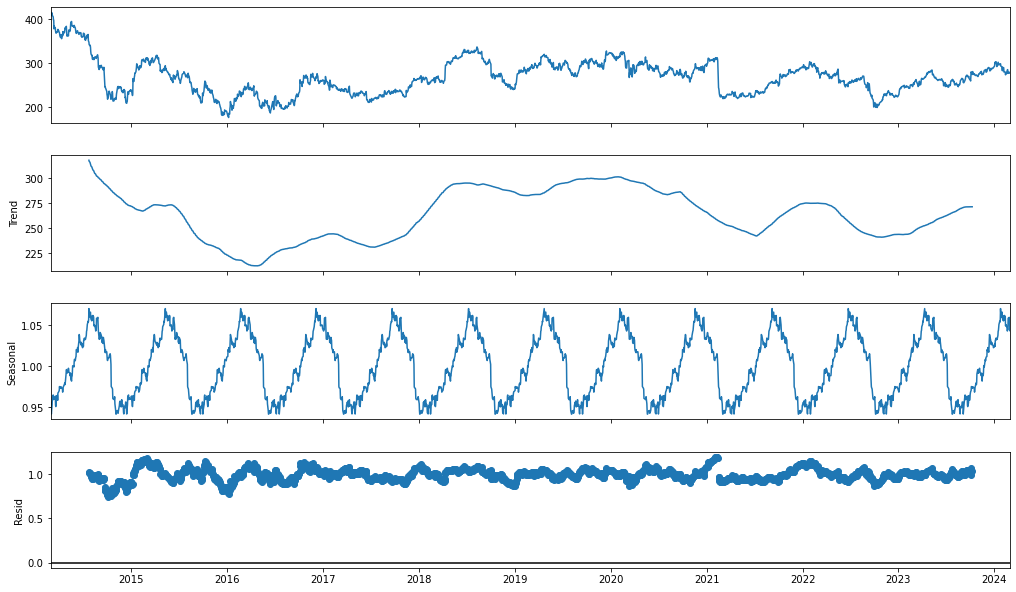

In [6]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(Tesco_close, model='multiplicative', period = 200)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

In [7]:
df_tesco = Tesco_close[['Close']]
df_tesco

,Close
Date,
2014-02-28,416.986389
2014-03-03,408.689789
2014-03-04,415.339813
2014-03-05,414.833099
2014-03-06,410.653107
...,...
2024-02-23,279.700012
2024-02-26,278.500000
2024-02-27,277.600006


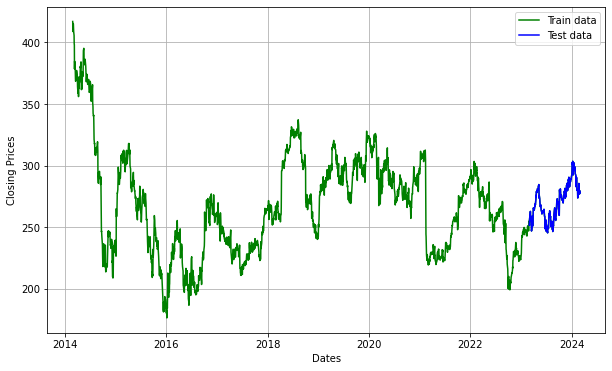

In [8]:
#split data into train and training set
train_data, test_data = df_tesco.iloc[0:int(len(df_tesco)*0.9)], df_tesco.iloc[int(len(df_tesco)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_tesco, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()